# 소프트맥스 회귀

## 다항분류(다중 클래스 분류)의 이해

### 1) 다항 분류
- 이진 분류 : 두 개의 선택지 중 하나를 고르는 문제
- 다항 분류 : 세 개 이상의 선택지 중 하나를 고르는 문제

### 2) 소프트맥스 함수
- 다항 분류 활성화 함수
- 뉴런의 출력값에 대하여 class 분류를 위하여 마지막 단계에서 출력값에 대한 정규화를 해주는 함수.
- 결과물의 수치의 합은 언제나 1.0이다.
- 소프트맥스 함수의 출력값은 확률로 해석할 수 있다.

> 사진속 인물이 지금 슬픈 표정인지, 웃는 표정인지, 화난 표정인지 확률적으로 수치화한다고 했을때, 슬픔(11%), 웃음(29%), 화남(60%)과 같이 확률적 분류를 할 때 용이

![img](./res/softmax.png)

- exp(x)는 지수함수(Exponential Function)이다. (e는 자연상수)
- n은 출력층의 뉴련수, yk는 그 중 k번째 출력을 뜻한다.

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, pivot_table
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

## #02. 데이터셋 준비하기

- 아이리스(붓꽃)의 꽃잎에 대한 각 부분의 너비와 길이 등을 측정한 데이터이며, 150개의 레코드로 구성
- 꽃받침의 길이, 너비, 꽃잎의 길이, 너비 등을 토대로 3가지로 나뉘는 붓꽃의 종류를 분류하는 학습모델을 구성할 수 있다.

In [2]:
origin = read_excel("https://data.hossam.kr/F03/iris.xlsx")
origin.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isna().sum()

Sepal.Length    0
Sepal.Width     0
Petal.Length    0
Petal.Width     0
Species         0
dtype: int64

### 종속변수 라벨링을 위해 값의 종류 확인

In [4]:
uni = origin['Species'].unique()
uni

array(['setosa', 'versicolor', 'virginica'], dtype=object)

### 종속변수 라벨링

In [5]:
# cat : 객체
origin['Species'] = origin['Species'].astype('category').cat.rename_categories({'setosa':0, 'versicolor':1, 'virginica':2})
origin['Species'].value_counts()

Species
0    50
1    50
2    50
Name: count, dtype: int64

## #04. 탐색적 데이터 분석

### 기초통계량

In [6]:
origin.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### 산점도 행렬 확인

> 종속변수로 'hue'를 적용했을때 뚜렷한 군집을 나타내는지 확인하기 위함

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


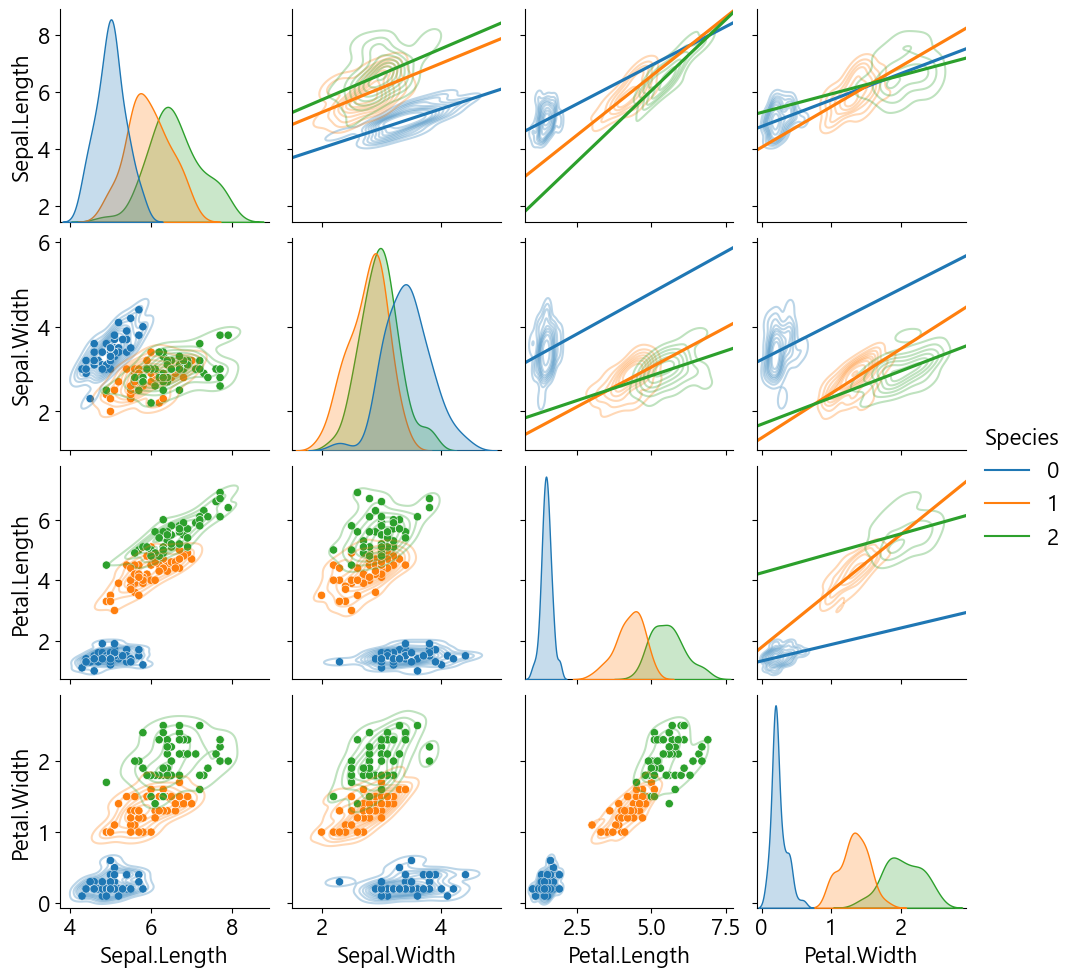

In [7]:
ax = sb.pairplot(origin, hue='Species', kind='kde', plot_kws={'alpha':0.3})
ax.map_lower(sb.scatterplot)
ax.map_upper(sb.regplot, scatter=False, truncate=False, ci=False)
plt.show()
plt.close()

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [8]:
np.random.seed(777)

### 훈련데이터(독립변수)와 레이블(종속변수)구분하기

In [9]:
x = origin.drop(['Species'], axis=1)
y = origin['Species']
x.shape, y.shape

((150, 4), (150,))

### 종속변수에 대한 one-hot-encoding
통상적인 더미변수 처리.

단 계산(회귀식)을 위한 처리가 아닌 분류를 위한 처리이므로 1번째 항목을 제외해서는 안된다.

In [10]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: Species, Length: 150, dtype: category
Categories (3, int64): [0, 1, 2]

In [11]:
# get_dummies 대신 to_categorical : 확률로 분류해야하기 때문에 
y_cate = to_categorical(y)
y_cate

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

### 훈련데이터와 검증데이터로 분할

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x,y_cate,test_size=0.3, random_state=777)
print("훈련용 데이터셋 크기: %s, 훈련용 레이블셋 크기: %s " %(x_train.shape, y_train.shape))
print("검증용 데이터셋 크기: %s, 검증용 레이블셋 크기: %s " %(x_test.shape, y_test.shape))

훈련용 데이터셋 크기: (105, 4), 훈련용 레이블셋 크기: (105, 3) 
검증용 데이터셋 크기: (45, 4), 검증용 레이블셋 크기: (45, 3) 


## #06. 모델개발

### 모델정의

In [13]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4, )))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 515 (2.01 KB)
Trainable params: 515 (2.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [14]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
4/4 [==============================] - 1s 102ms/step - loss: 1.8868 - acc: 0.3143 - val_loss: 1.6991 - val_acc: 0.3778 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 1.6102 - acc: 0.3143 - val_loss: 1.4850 - val_acc: 0.3778 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 1.4072 - acc: 0.3143 - val_loss: 1.3300 - val_acc: 0.3778 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 38ms/step - loss: 1.2429 - acc: 0.3143 - val_loss: 1.2293 - val_acc: 0.4222 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 15ms/step - loss: 1.1539 - acc: 0.5333 - val_loss: 1.1543 - val_acc: 0.6222 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 19ms/step - loss: 1.0893 - acc: 0.6762 - val_loss: 1.1036 - val_acc: 0.5111 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 19ms/step - loss: 1.0464 - acc: 0.5143 - val_loss: 1.0670 - val_acc: 0.2444 - lr: 0.001

## #07. 학습 결과 평가

In [16]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs', inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,1.886777,0.314286,1.699123,0.377778,0.0010
2,1.610220,0.314286,1.485025,0.377778,0.0010
3,1.407248,0.314286,1.330030,0.377778,0.0010
4,1.242924,0.314286,1.229347,0.422222,0.0010
5,1.153851,0.533333,1.154304,0.622222,0.0010
...,...,...,...,...,...
75,0.376019,0.980952,0.336140,1.000000,0.0010
76,0.372509,0.971429,0.341968,1.000000,0.0010
77,0.373302,0.923810,0.346431,0.977778,0.0010


In [17]:
column_name = result_df.columns
column_name

Index(['loss', 'acc', 'val_loss', 'val_acc', 'lr'], dtype='object')

In [18]:
train_column_name = [column_name[0], column_name[1]]
test_column_name = [column_name[2], column_name[3]]

In [19]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

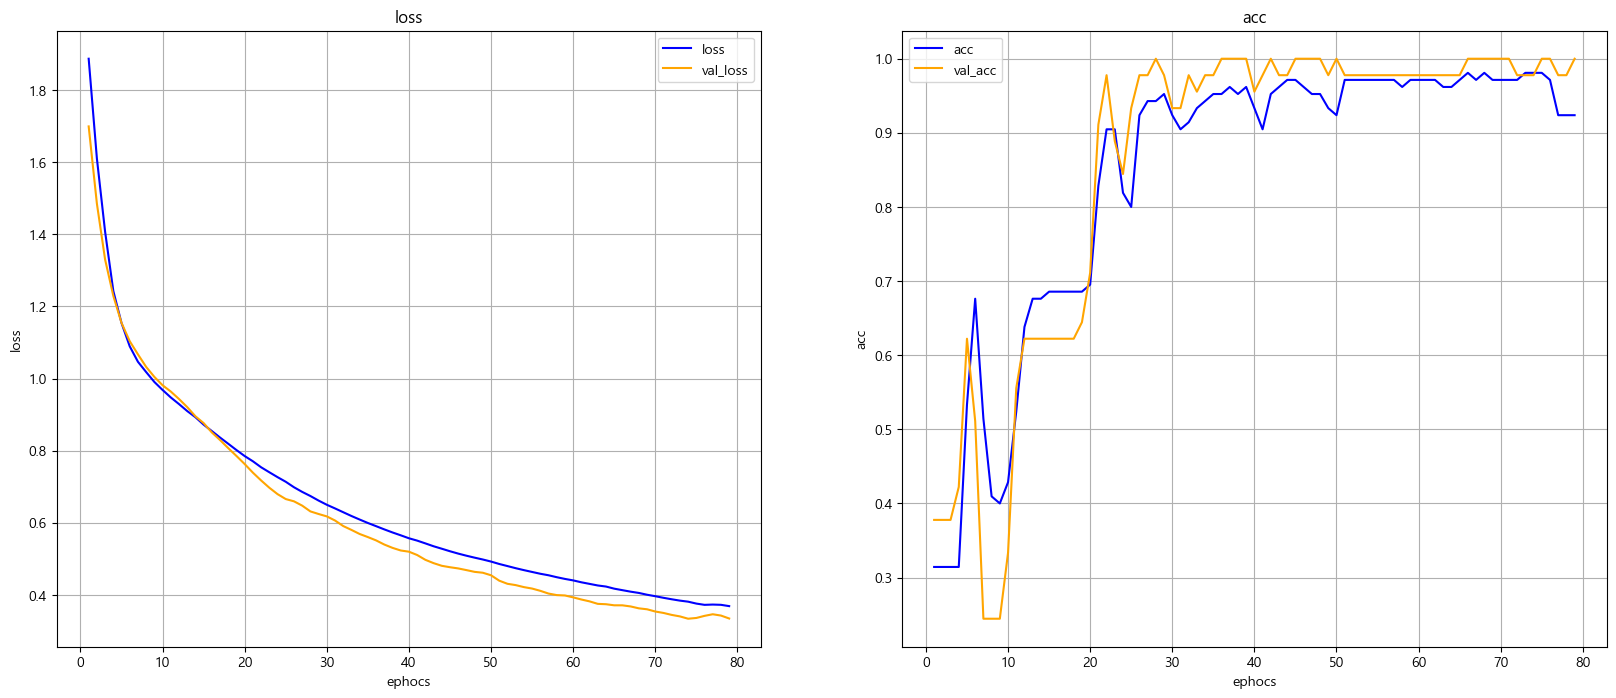

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
for i, v in enumerate(ax):
    sb.lineplot(x=result_df.index, y=train_column_name[i], data=result_df, color='blue', label=train_column_name[i], ax=v)
    sb.lineplot(x=result_df.index, y=test_column_name[i], data=result_df, color='orange', label=test_column_name[i], ax=v)
    v.set_title(train_column_name[i])
    v.set_xlabel('ephocs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()

plt.show()
plt.close()

In [22]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

4/4 [==============================] - 0s 2ms/step - loss: 0.3664 - acc: 0.9238
최종 훈련 손실률: 0.366374, 최종 훈련 정확도: 0.923810
2/2 [==============================] - 0s 4ms/step - loss: 0.3347 - acc: 1.0000
최종 검증 손실률: 0.334670, 최종 검증 정확도: 1.000000


## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [26]:
results = model.predict(x_test)
# results.shape
data_count, case_count = results.shape
print("%d의 검증데이터가 각각 %d개의 경우의 수를 갖는다" % (data_count, case_count))

print(results)

2/2 [==============================] - 0s 3ms/step
45의 검증데이터가 각각 3개의 경우의 수를 갖는다
[[0.00435504 0.38523763 0.6104073 ]
 [0.90358096 0.08395323 0.01246582]
 [0.00657554 0.3763264  0.6170981 ]
 [0.01009056 0.32766423 0.66224515]
 [0.03064062 0.6002858  0.3690735 ]
 [0.9464003  0.04765116 0.00594852]
 [0.00561135 0.3725934  0.62179524]
 [0.00659456 0.32294804 0.6704574 ]
 [0.9377617  0.05563737 0.0066009 ]
 [0.93460315 0.05723386 0.00816309]
 [0.00470125 0.38479346 0.6105052 ]
 [0.03149763 0.62862056 0.3398818 ]
 [0.05034847 0.61056393 0.33908764]
 [0.01293792 0.45318395 0.533878  ]
 [0.01062885 0.36245546 0.62691563]
 [0.0082714  0.41240594 0.57932264]
 [0.89701337 0.08902171 0.01396493]
 [0.01727334 0.46273178 0.51999485]
 [0.8710928  0.1118273  0.01707985]
 [0.04538287 0.614992   0.33962512]
 [0.05866251 0.66226494 0.27907255]
 [0.03181746 0.6603582  0.3078243 ]
 [0.00290004 0.326188   0.67091197]
 [0.90010154 0.0869858  0.01291259]
 [0.01454557 0.44837865 0.53707576]
 [0.89001447 0.09491

### 가장 큰 확률 값의 인덱스들만 별도의 리스트로 생성

In [27]:
arg_results = np.argmax(results, axis=-1)
arg_results

array([2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 1, 1, 2, 2, 2, 0, 2, 0, 1, 1, 1,
       2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1,
       0], dtype=int64)

### 결과 데이터 셋 구성

In [28]:
result_df = DataFrame({
    '실제값':np.argmax(y_test, axis=-1),
    '분류결과':arg_results
})

result_df

,실제값,분류결과
0,2,2
1,0,0
2,2,2
3,2,2
4,1,1
5,0,0
6,2,2
7,2,2
8,0,0
9,0,0


### 컬럼에 따른 값의 종류 형태로 데이터 재배치

In [29]:
mdf = result_df.melt()
mdf.reset_index(inplace=True)
mdf

,index,variable,value
0,0,실제값,2
1,1,실제값,0
2,2,실제값,2
3,3,실제값,2
4,4,실제값,1
...,...,...,...
85,85,분류결과,0
86,86,분류결과,2
87,87,분류결과,1
88,88,분류결과,1


In [30]:
df = pivot_table(mdf, index='value', columns='variable', values='index', aggfunc='count')
df

variable,분류결과,실제값
value,,
0,17,17
1,11,11
2,17,17


In [31]:
cm = confusion_matrix(result_df['실제값'], result_df['분류결과'])
cmdf1 = DataFrame(cm, index=[['실제값', '실제값', '실제값'], [0,1,2]],
                  columns=[['분류결과', '분류결과', '분류결과'], [0,1,2]])

cmdf1

분류결과        
         0   1   2
실제값 0   17   0   0
    1    0  11   0
    2    0   0  17